# Without attention

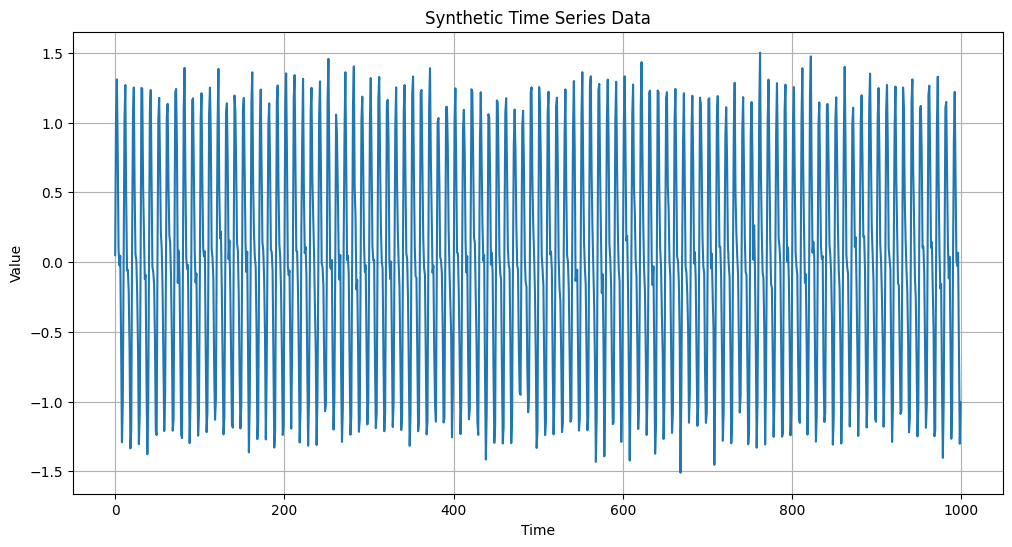

Input batch shape: torch.Size([128, 24, 1])
Target batch shape: torch.Size([128, 12, 1])
Epoch [10/100], Loss: 0.042036
Epoch [20/100], Loss: 0.013575
Epoch [30/100], Loss: 0.008208
Epoch [40/100], Loss: 0.005343
Epoch [50/100], Loss: 0.004857
Epoch [60/100], Loss: 0.004697
Epoch [70/100], Loss: 0.004608
Epoch [80/100], Loss: 0.004658
Epoch [90/100], Loss: 0.004787
Epoch [100/100], Loss: 0.004567


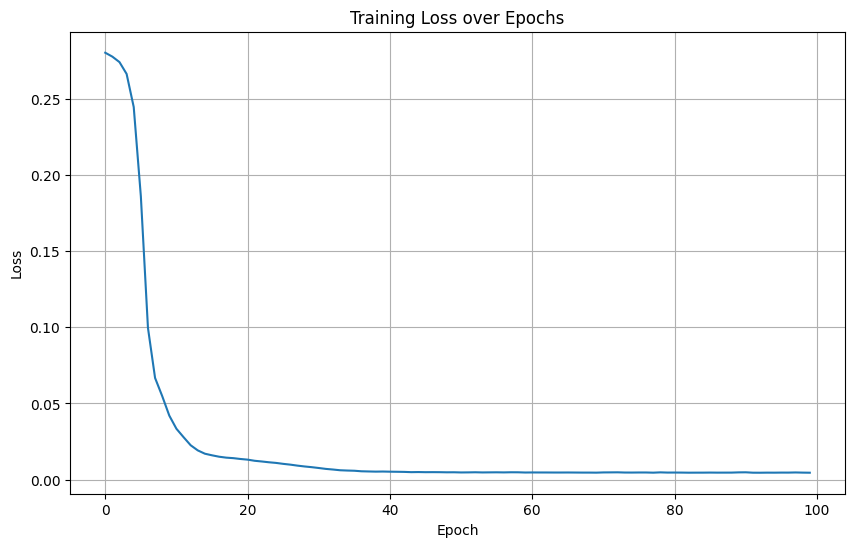

Test Loss: 0.004641


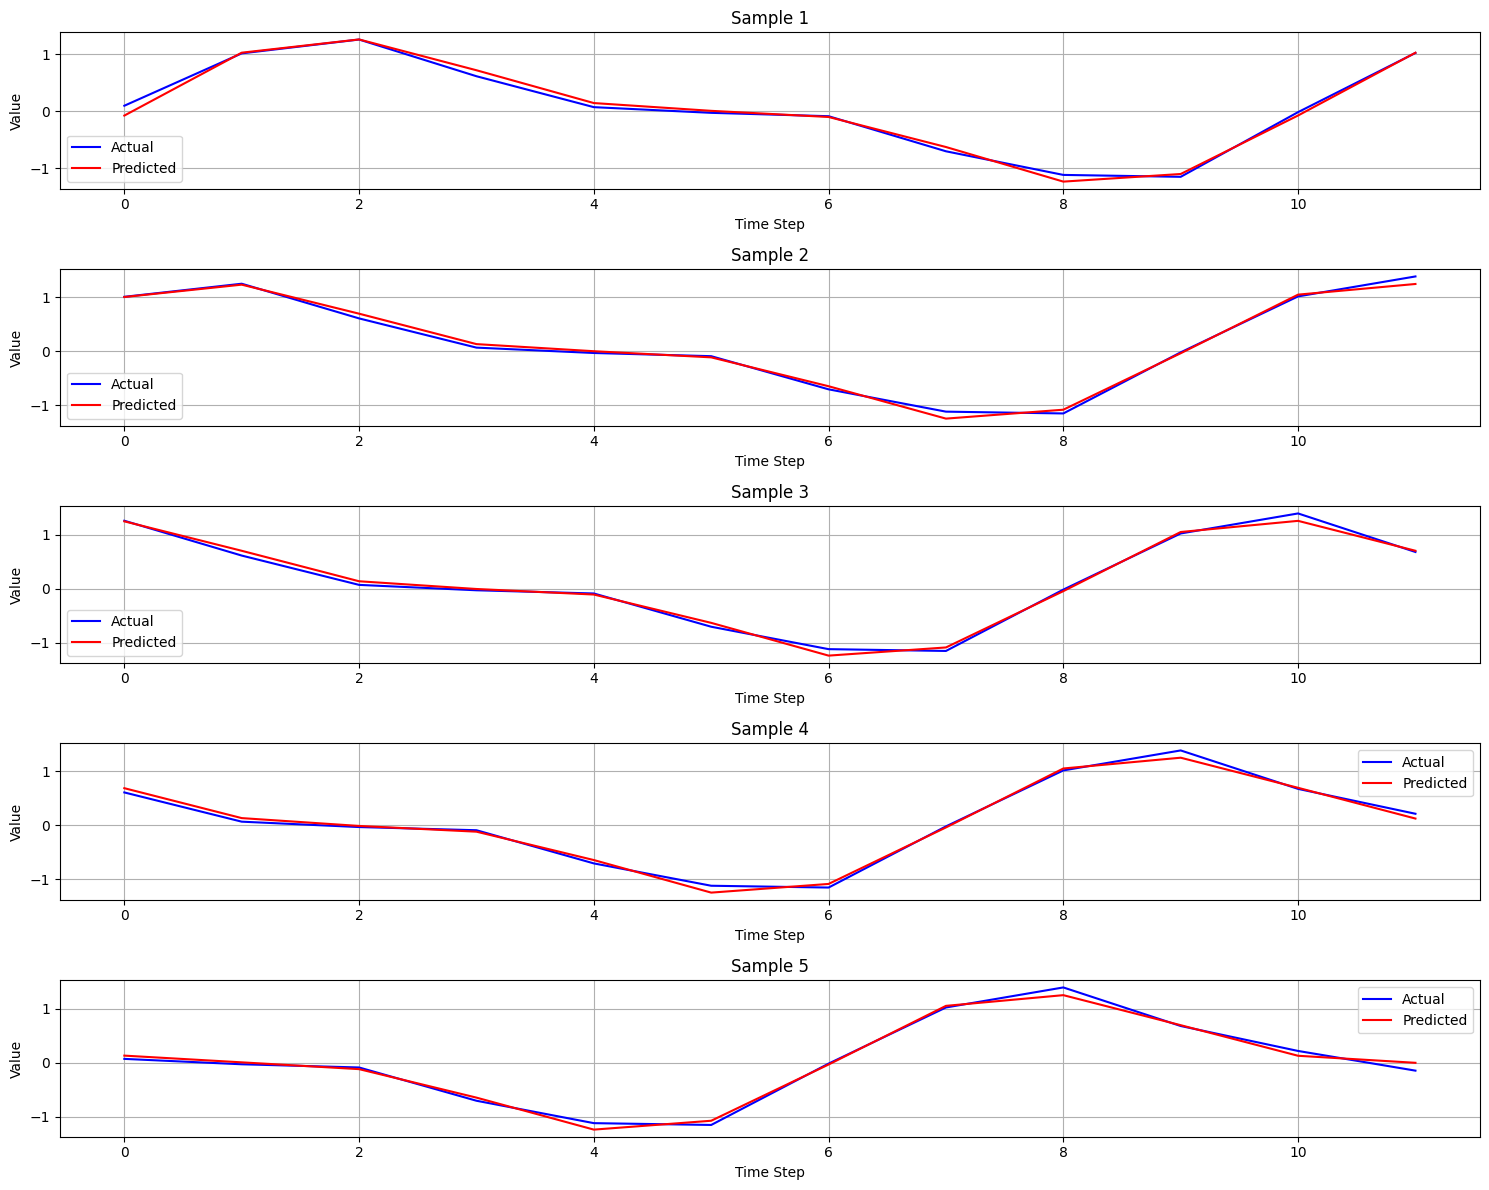

Mean Absolute Error (MAE): 0.0813
Root Mean Squared Error (RMSE): 0.1016
Mean Absolute Percentage Error (MAPE): 58.1211%


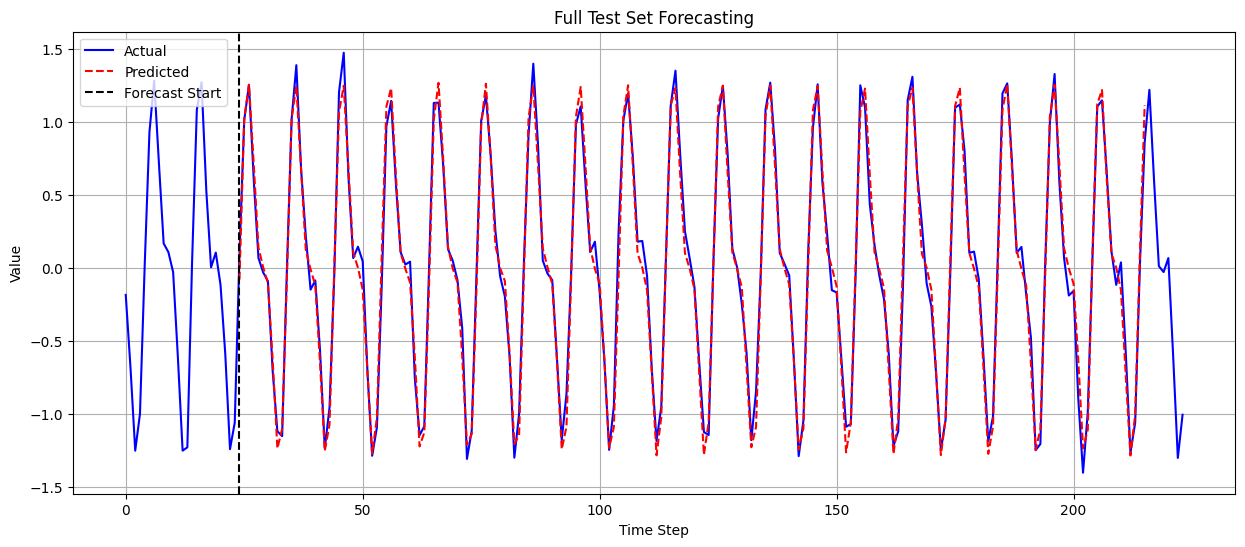

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import math

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a synthetic time series
def generate_sine_wave(seq_length=1000, freq=0.1, noise_level=0.1):
    """Generate a synthetic sine wave with noise for time series forecasting"""
    x = np.arange(0, seq_length)
    # Create a sine wave with increasing frequency
    y = np.sin(2 * np.pi * freq * x) + 0.5 * np.sin(2 * np.pi * freq * 2 * x)
    # Add some noise
    noise = np.random.normal(0, noise_level, seq_length)
    y += noise
    return y

# Generate the time series data
time_series = generate_sine_wave(seq_length=1000)

# Plot the raw time series
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
time_series_normalized = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Create windowed data for sequence-to-sequence learning
class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, input_window=24, output_window=12, stride=1):
        """
        Create a dataset of windowed input/output sequences
        
        Args:
            time_series: The time series data (normalized)
            input_window: Number of input time steps
            output_window: Number of output time steps to predict
            stride: Step size between consecutive windows
        """
        self.time_series = time_series
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride
        
        # Calculate valid start indices for windows
        self.indices = np.arange(len(time_series) - (input_window + output_window) + 1, step=stride)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # Get the starting index for this window
        start_idx = self.indices[idx]
        
        # Extract input and target sequences
        input_seq = self.time_series[start_idx:start_idx + self.input_window]
        target_seq = self.time_series[start_idx + self.input_window:start_idx + self.input_window + self.output_window]
        
        # Convert to PyTorch tensors
        input_seq = torch.FloatTensor(input_seq).unsqueeze(1)  # Shape: [input_window, 1]
        target_seq = torch.FloatTensor(target_seq).unsqueeze(1)  # Shape: [output_window, 1]
        
        return input_seq, target_seq

# Create train/test splits
train_size = int(0.8 * len(time_series_normalized))
test_size = len(time_series_normalized) - train_size

train_data = time_series_normalized[:train_size]
test_data = time_series_normalized[train_size - 24:]  # Include some overlap for context

# Define dataset parameters
input_window = 24  # 24 time steps of history
output_window = 12  # Predict 12 time steps into the future
batch_size = 128

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, input_window, output_window)
test_dataset = TimeSeriesDataset(test_data, input_window, output_window)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Let's see what a batch looks like
for x_batch, y_batch in train_loader:
    print(f"Input batch shape: {x_batch.shape}")  # [batch_size, input_window, 1]
    print(f"Target batch shape: {y_batch.shape}")  # [batch_size, output_window, 1]
    break

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers, 
                           batch_first=False)  # Input shape: [seq_len, batch, input_size]
    
    def forward(self, x):
        # x shape: [seq_len, batch, features]
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers, 
                           batch_first=False)  # Input shape: [seq_len, batch, input_size]
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden, cell):
        # x shape: [1, batch, features] - just one time step
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.fc(output.squeeze(0))  # Remove time dimension and apply linear layer
        return prediction, hidden, cell

# Combine Encoder and Decoder into a Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_window, num_layers=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, output_size, num_layers)
        self.output_window = output_window
    
    def forward(self, source, target=None, teacher_forcing_ratio=0.5):
        batch_size = source.shape[1]
        seq_len = source.shape[0]
        
        # Initialize the output tensor
        outputs = torch.zeros(self.output_window, batch_size, 1)
        
        # Pass source sequence through encoder
        encoder_outputs, hidden, cell = self.encoder(source)
        
        # First decoder input is the last value of the input sequence
        decoder_input = source[-1].unsqueeze(0)  # Shape: [1, batch, 1]
        
        # Iteratively predict each time step in the output window
        for t in range(self.output_window):
            # Pass through decoder
            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            
            # Store the prediction
            outputs[t] = decoder_output
            
            # Determine next input (teacher forcing or previous prediction)
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Use ground truth as next input (teacher forcing)
                decoder_input = target[t].unsqueeze(0)
            else:
                # Use current prediction as next input
                decoder_input = decoder_output.unsqueeze(0)
                
        return outputs

# Define model parameters
input_size = 1  # Univariate time series
hidden_size = 64
output_size = 1
num_layers = 2

# Initialize the model
model = Seq2Seq(input_size, hidden_size, output_size, output_window, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Move tensors to the correct dimensions [seq_len, batch, features]
            x_batch = x_batch.permute(1, 0, 2)
            y_batch = y_batch.permute(1, 0, 2)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
            
            # Calculate loss
            loss = criterion(output, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return losses

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    predictions = []
    actual_values = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # Move tensors to the correct dimensions [seq_len, batch, features]
            x_batch = x_batch.permute(1, 0, 2)
            y_batch = y_batch.permute(1, 0, 2)
            
            # Forward pass
            output = model(x_batch, teacher_forcing_ratio=0)
            
            # Calculate loss
            loss = criterion(output, y_batch)
            test_loss += loss.item()
            
            # Store predictions and actual values
            predictions.append(output.permute(1, 0, 2))  # [batch, seq, features]
            actual_values.append(y_batch.permute(1, 0, 2))  # [batch, seq, features]
    
    # Concatenate batches
    predictions = torch.cat(predictions, dim=0).numpy()
    actual_values = torch.cat(actual_values, dim=0).numpy()
    
    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.6f}')
    
    return predictions, actual_values, avg_loss

# Train the model
losses = train_model(model, train_loader, criterion, optimizer, epochs=100)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate the model
predictions, actual_values, test_loss = evaluate_model(model, test_loader, criterion)

# Inverse transform the normalized values
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
actual_values_original = scaler.inverse_transform(actual_values.reshape(-1, 1)).reshape(actual_values.shape)

# Function to visualize predictions
def plot_predictions(predictions, actual_values, num_samples=5):
    """Plot predictions vs actual values for a few random samples"""
    plt.figure(figsize=(15, 12))
    
    for i in range(min(num_samples, len(predictions))):
        plt.subplot(num_samples, 1, i+1)
        
        # Plot actual values
        plt.plot(actual_values[i, :, 0], 'b-', label='Actual')
        
        # Plot predictions
        plt.plot(predictions[i, :, 0], 'r-', label='Predicted')
        
        plt.title(f'Sample {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualize a few predictions
plot_predictions(predictions_original, actual_values_original, num_samples=5)

# Calculate error metrics
def calculate_metrics(predictions, actual_values):
    """Calculate common error metrics for time series forecasting"""
    # Reshape to 2D arrays for calculations
    y_true = actual_values.reshape(-1)
    y_pred = predictions.reshape(-1)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true + 1e-10))) * 100
    
    return mae, rmse, mape

# Calculate and print metrics
mae, rmse, mape = calculate_metrics(predictions_original, actual_values_original)
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

# Let's also visualize how well we do on the test data by plotting the entire prediction
def plot_full_test_prediction(test_data, input_window, output_window, model, scaler):
    """Generate a forecast for the entire test dataset"""
    model.eval()
    predictions = []
    
    # Convert test data to tensor
    test_tensor = torch.FloatTensor(test_data)
    
    # Start with the first window
    current_input = test_tensor[:input_window].unsqueeze(1)  # [input_window, 1]
    
    # Initial prediction covers the first output_window time steps
    current_input_reshaped = current_input.unsqueeze(1).permute(0, 1, 2)  # [seq_len, batch=1, features=1]
    with torch.no_grad():
        output = model(current_input_reshaped, teacher_forcing_ratio=0)
    
    # Get the predicted values for the first window
    first_pred = output.permute(1, 0, 2).numpy()[0, :, 0]  # [output_window]
    predictions.extend(first_pred)
    
    # Generate predictions for the rest of the test set in non-overlapping windows
    steps = (len(test_data) - input_window) // output_window
    
    for step in range(1, steps):
        # Update input window to include the last prediction
        start_idx = step * output_window
        if start_idx + input_window <= len(test_data):
            current_input = test_tensor[start_idx:start_idx + input_window].unsqueeze(1)
            current_input_reshaped = current_input.unsqueeze(1).permute(0, 1, 2)
            
            with torch.no_grad():
                output = model(current_input_reshaped, teacher_forcing_ratio=0)
            
            next_pred = output.permute(1, 0, 2).numpy()[0, :, 0]
            predictions.extend(next_pred)
    
    # Convert predictions back to original scale
    predictions_array = np.array(predictions[:len(test_data) - input_window]).reshape(-1, 1)
    predictions_original = scaler.inverse_transform(predictions_array).flatten()
    
    # Original test data
    test_data_original = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(test_data)), test_data_original, 'b-', label='Actual')
    plt.plot(range(input_window, input_window + len(predictions_original)), predictions_original, 'r--', label='Predicted')
    plt.axvline(x=input_window, color='k', linestyle='--', label='Forecast Start')
    plt.title('Full Test Set Forecasting')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the full test set prediction
plot_full_test_prediction(test_data, input_window, output_window, model, scaler)

# Dot attention

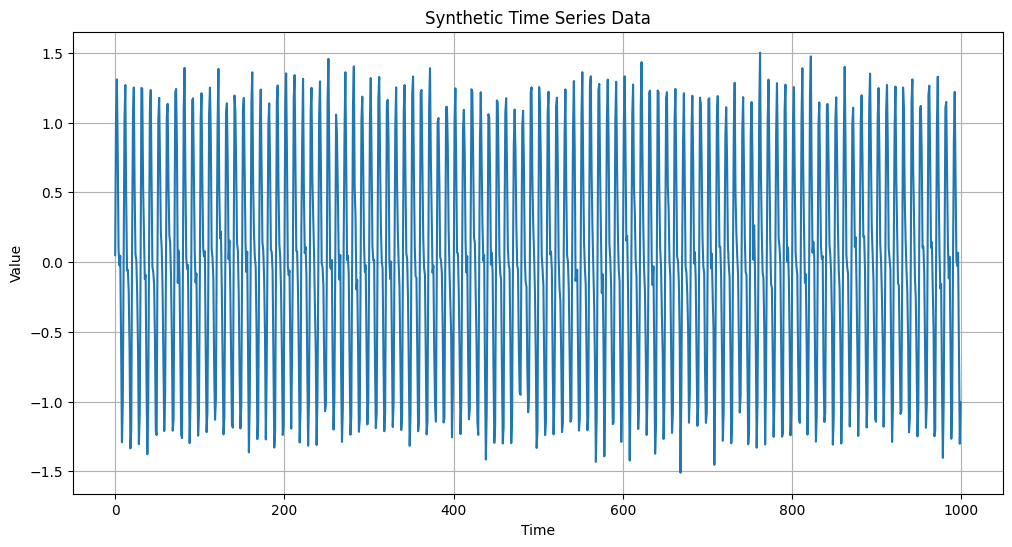

Input batch shape: torch.Size([16, 24, 1])
Target batch shape: torch.Size([16, 12, 1])
Epoch [10/100], Loss: 0.005338
Epoch [20/100], Loss: 0.004863
Epoch [30/100], Loss: 0.004827
Epoch [40/100], Loss: 0.004989
Epoch [50/100], Loss: 0.004968
Epoch [60/100], Loss: 0.004806
Epoch [70/100], Loss: 0.004878
Epoch [80/100], Loss: 0.004655
Epoch [90/100], Loss: 0.004539
Epoch [100/100], Loss: 0.004636


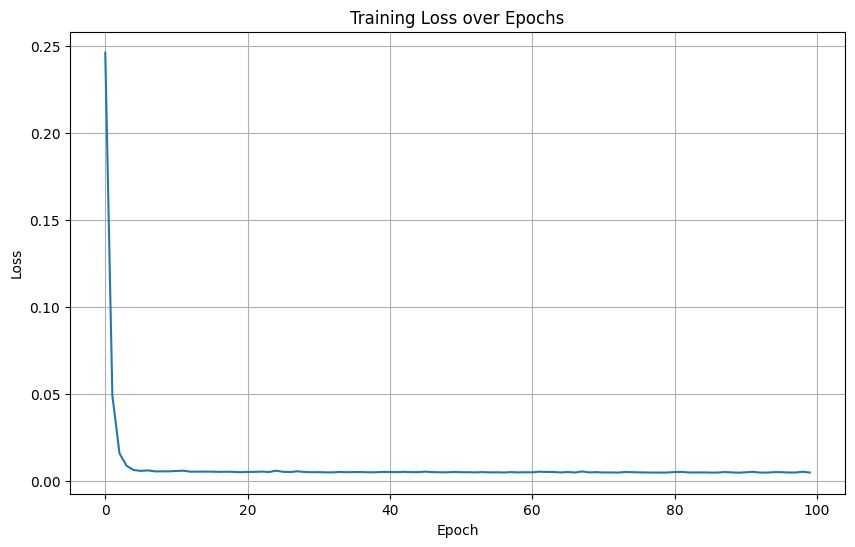

Test Loss: 0.004743


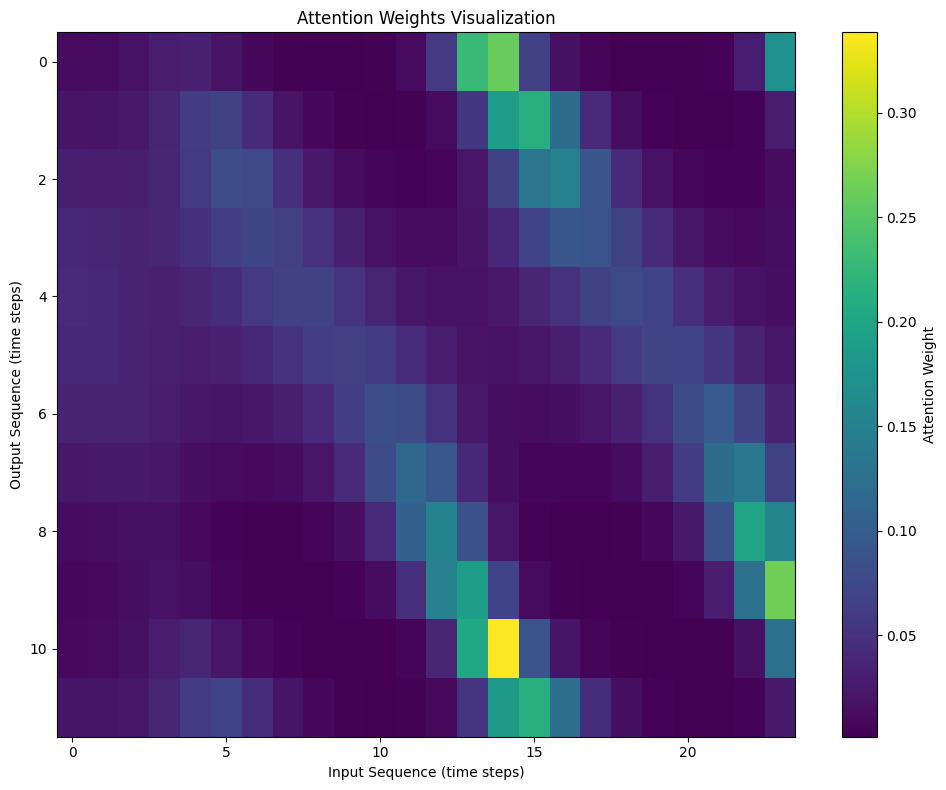

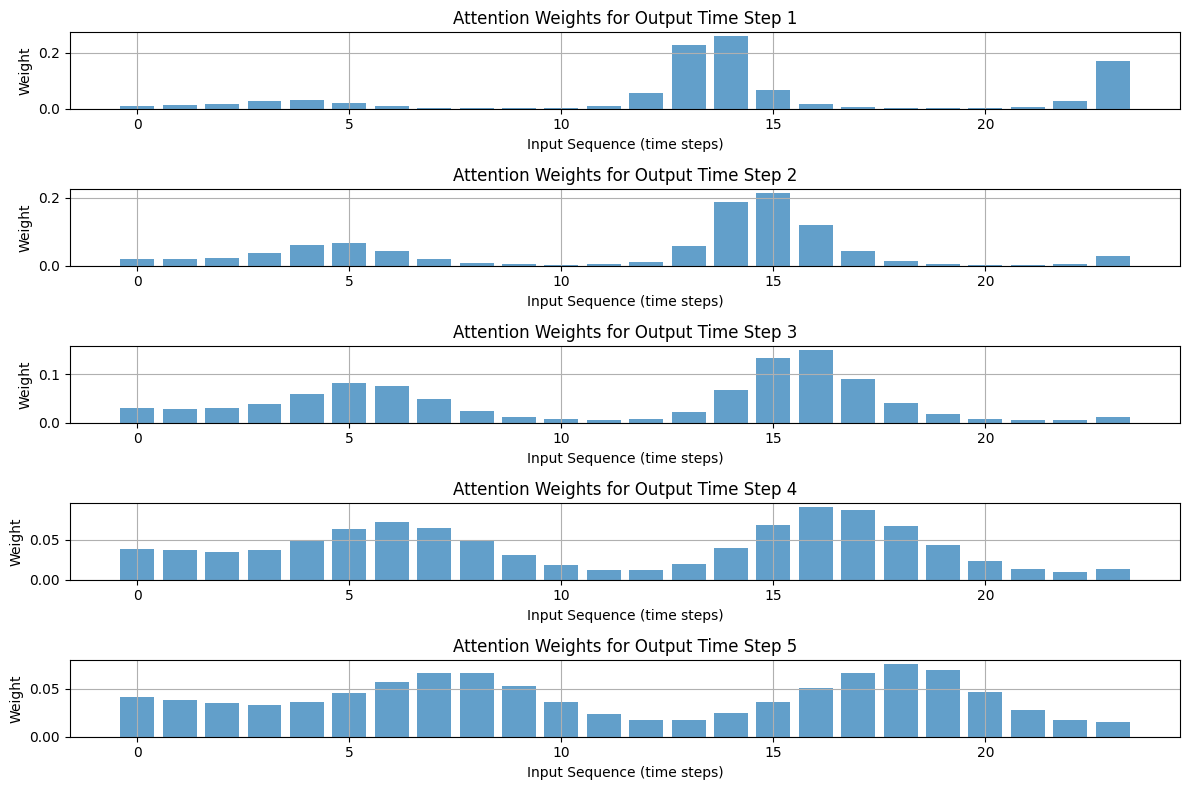

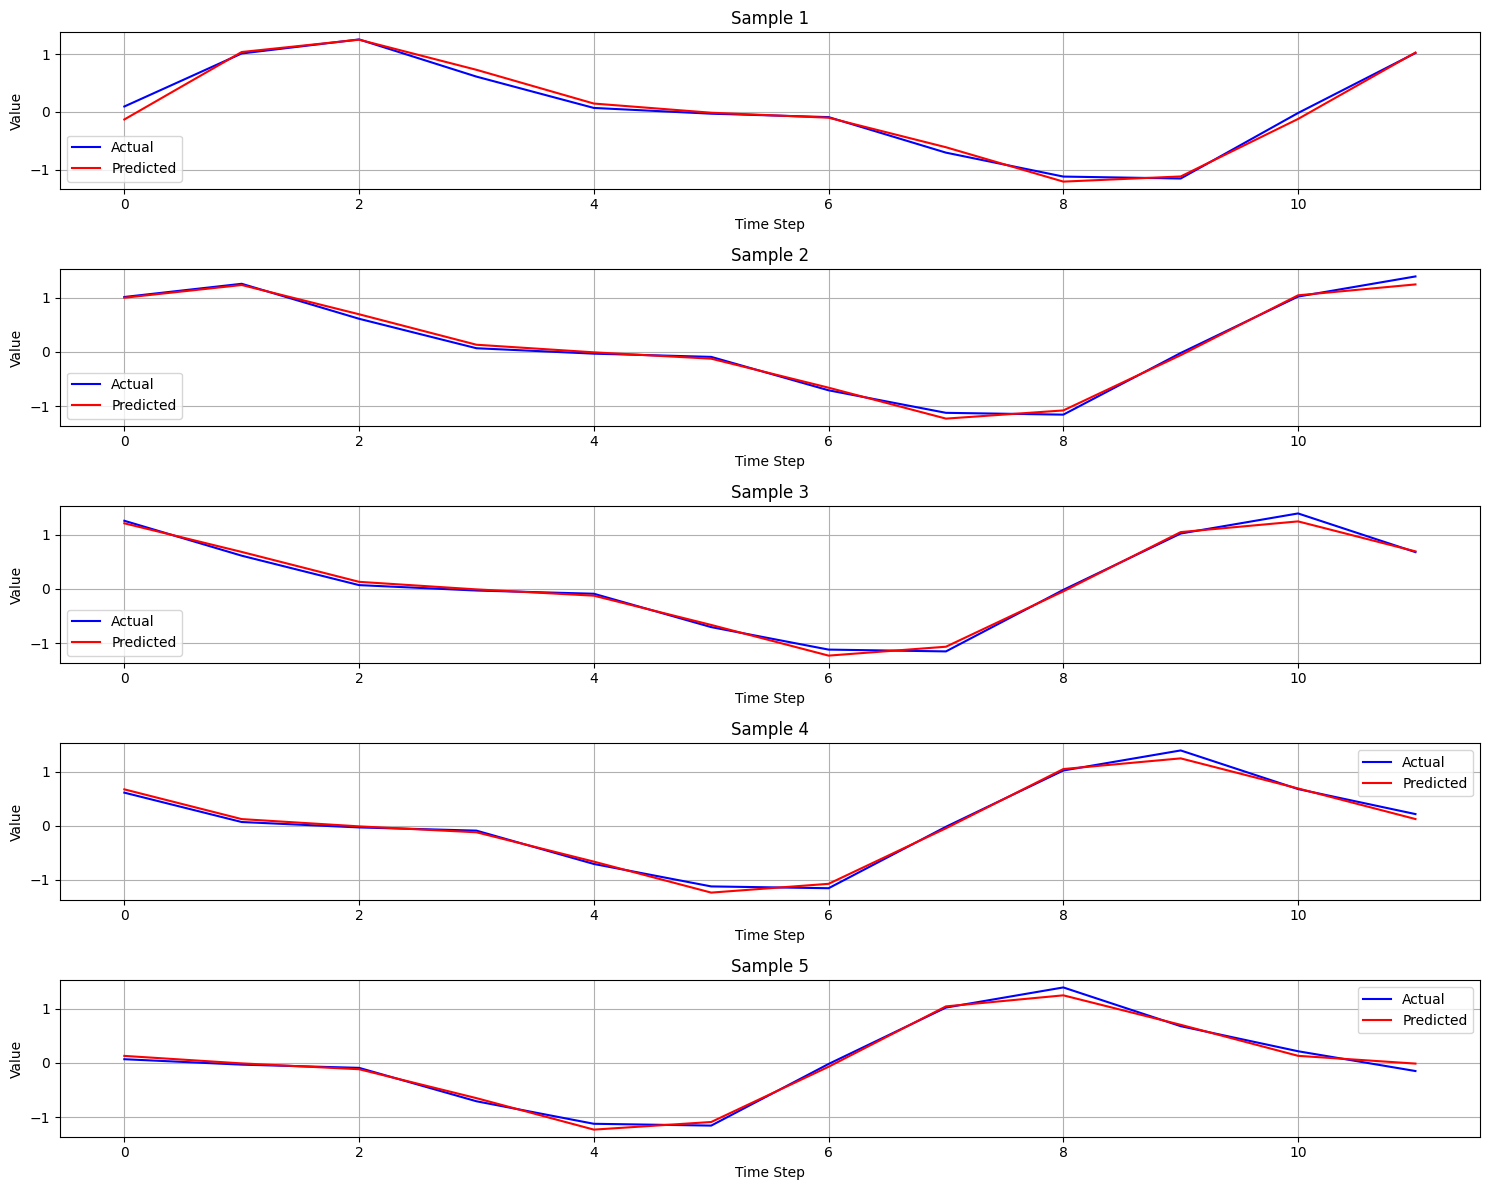

Mean Absolute Error (MAE): 0.0834
Root Mean Squared Error (RMSE): 0.1037
Mean Absolute Percentage Error (MAPE): 68.6185%


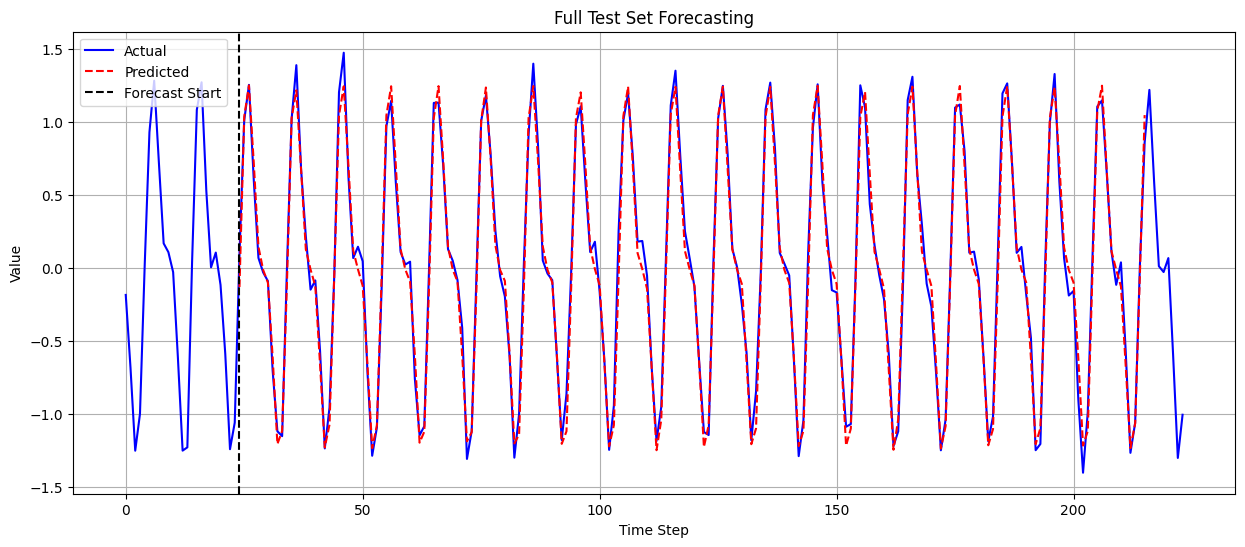

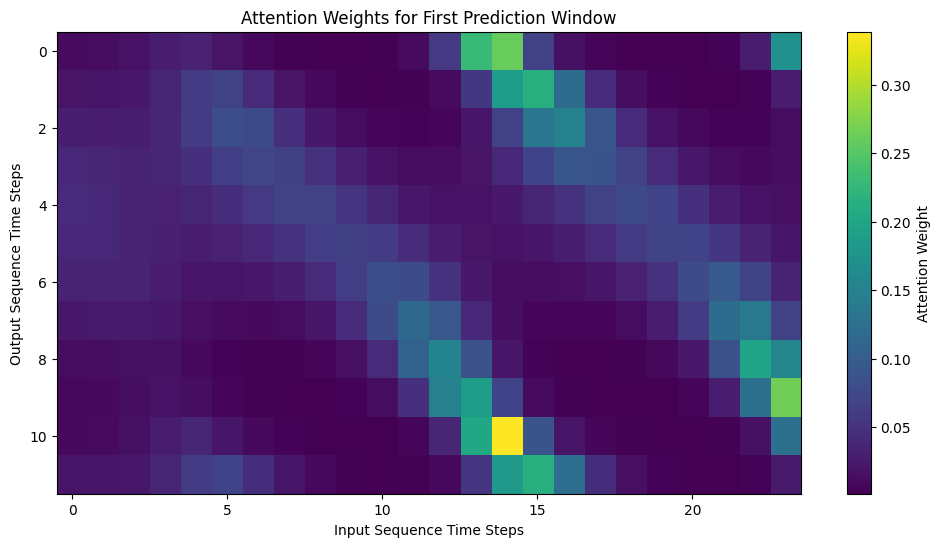

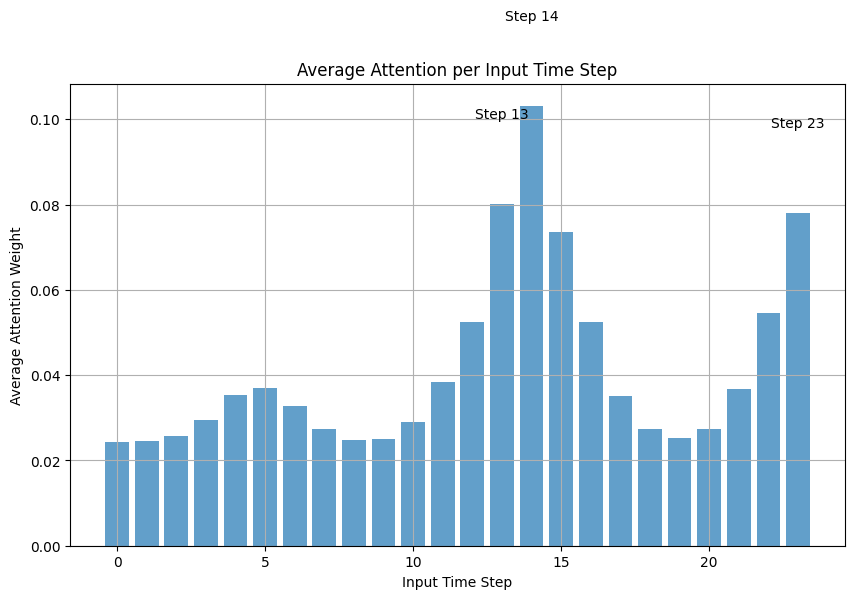

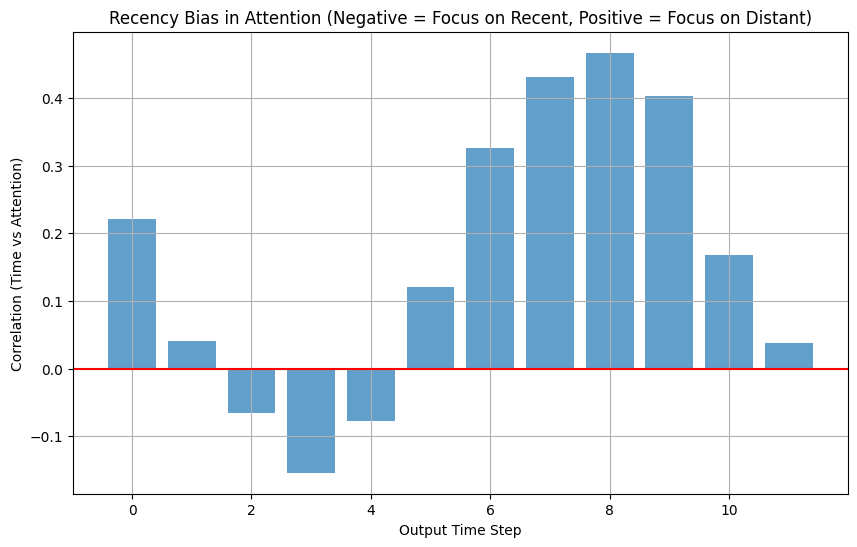

Attention Analysis Insights:
- Most attended input time steps: [14 13 23]
- Model somewhat focuses on distant past when making predictions


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import math

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a synthetic time series
def generate_sine_wave(seq_length=1000, freq=0.1, noise_level=0.1):
    """Generate a synthetic sine wave with noise for time series forecasting"""
    x = np.arange(0, seq_length)
    # Create a sine wave with increasing frequency
    y = np.sin(2 * np.pi * freq * x) + 0.5 * np.sin(2 * np.pi * freq * 2 * x)
    # Add some noise
    noise = np.random.normal(0, noise_level, seq_length)
    y += noise
    return y

# Generate the time series data
time_series = generate_sine_wave(seq_length=1000)

# Plot the raw time series
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
time_series_normalized = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Create windowed data for sequence-to-sequence learning
class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, input_window=24, output_window=12, stride=1):
        """
        Create a dataset of windowed input/output sequences
        
        Args:
            time_series: The time series data (normalized)
            input_window: Number of input time steps
            output_window: Number of output time steps to predict
            stride: Step size between consecutive windows
        """
        self.time_series = time_series
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride
        
        # Calculate valid start indices for windows
        self.indices = np.arange(len(time_series) - (input_window + output_window) + 1, step=stride)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # Get the starting index for this window
        start_idx = self.indices[idx]
        
        # Extract input and target sequences
        input_seq = self.time_series[start_idx:start_idx + self.input_window]
        target_seq = self.time_series[start_idx + self.input_window:start_idx + self.input_window + self.output_window]
        
        # Convert to PyTorch tensors
        input_seq = torch.FloatTensor(input_seq).unsqueeze(1)  # Shape: [input_window, 1]
        target_seq = torch.FloatTensor(target_seq).unsqueeze(1)  # Shape: [output_window, 1]
        
        return input_seq, target_seq

# Create train/test splits
train_size = int(0.8 * len(time_series_normalized))
test_size = len(time_series_normalized) - train_size

train_data = time_series_normalized[:train_size]
test_data = time_series_normalized[train_size - 24:]  # Include some overlap for context

# Define dataset parameters
input_window = 24  # 24 time steps of history
output_window = 12  # Predict 12 time steps into the future
batch_size = 16

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, input_window, output_window)
test_dataset = TimeSeriesDataset(test_data, input_window, output_window)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Let's see what a batch looks like
for x_batch, y_batch in train_loader:
    print(f"Input batch shape: {x_batch.shape}")  # [batch_size, input_window, 1]
    print(f"Target batch shape: {y_batch.shape}")  # [batch_size, output_window, 1]
    break

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers, 
                           batch_first=False)  # Input shape: [seq_len, batch, input_size]
    
    def forward(self, x):
        # x shape: [seq_len, batch, features]
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

# Define the Attention Layer
class DotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(DotAttention, self).__init__()
        self.hidden_size = hidden_size
        
        # Linear projection for attention scores
        self.attn = nn.Linear(hidden_size, hidden_size)
        
        # Linear projection for context vector and hidden state combination
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        
    def forward(self, hidden, encoder_outputs):
        # hidden shape: [num_layers, batch, hidden_size] -> take the last layer
        hidden_last_layer = hidden[-1]  # [batch, hidden_size]
        
        # Transform the hidden state
        attn_weights = torch.bmm(encoder_outputs.permute(1, 0, 2), 
                                hidden_last_layer.unsqueeze(2)).squeeze(2)
        
        # Apply softmax to get attention weights
        attn_weights = F.softmax(attn_weights, dim=1)  # [batch, seq_len]
        
        # Compute context vector using attention weights
        context = torch.bmm(attn_weights.unsqueeze(1), 
                           encoder_outputs.permute(1, 0, 2)).squeeze(1)  # [batch, hidden_size]
        
        # Combine context vector and hidden state
        output = torch.cat((context, hidden_last_layer), 1)  # [batch, hidden_size*2]
        output = self.fc(output)  # [batch, hidden_size]
        output = torch.tanh(output)
        
        return output, attn_weights

# Define the Decoder with Attention
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers, 
                           batch_first=False)  # Input shape: [seq_len, batch, input_size]
        
        # Attention layer
        self.attention = DotAttention(hidden_size)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden, cell, encoder_outputs):
        # x shape: [1, batch, features] - just one time step
        lstm_output, (hidden, cell) = self.lstm(x, (hidden, cell))
        
        # Apply attention
        attn_output, attn_weights = self.attention(hidden, encoder_outputs)
        
        # Use attention output to generate prediction
        prediction = self.fc(attn_output)
        
        return prediction, hidden, cell, attn_weights

# Add import for attention
import torch.nn.functional as F

# Combine Encoder and Decoder into a Seq2Seq model with Attention
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_window, num_layers=1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, output_size, num_layers)
        self.output_window = output_window
    
    def forward(self, source, target=None, teacher_forcing_ratio=0.5):
        batch_size = source.shape[1]
        seq_len = source.shape[0]
        
        # Initialize the output tensor
        outputs = torch.zeros(self.output_window, batch_size, 1)
        
        # Store attention weights for visualization
        attention_weights = torch.zeros(self.output_window, batch_size, seq_len)
        
        # Pass source sequence through encoder
        encoder_outputs, hidden, cell = self.encoder(source)
        
        # First decoder input is the last value of the input sequence
        decoder_input = source[-1].unsqueeze(0)  # Shape: [1, batch, 1]
        
        # Iteratively predict each time step in the output window
        for t in range(self.output_window):
            # Pass through decoder with attention
            decoder_output, hidden, cell, attn_weights = self.decoder(
                decoder_input, hidden, cell, encoder_outputs)
            
            # Store the prediction and attention weights
            outputs[t] = decoder_output
            attention_weights[t] = attn_weights
            
            # Determine next input (teacher forcing or previous prediction)
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Use ground truth as next input (teacher forcing)
                decoder_input = target[t].unsqueeze(0)
            else:
                # Use current prediction as next input
                decoder_input = decoder_output.unsqueeze(0)
                
        return outputs, attention_weights

# Define model parameters
input_size = 1  # Univariate time series
hidden_size = 64
output_size = 1
num_layers = 2

# Initialize the model
model = Seq2Seq(input_size, hidden_size, output_size, output_window, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Move tensors to the correct dimensions [seq_len, batch, features]
            x_batch = x_batch.permute(1, 0, 2)
            y_batch = y_batch.permute(1, 0, 2)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with attention
            output, _ = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
            
            # Calculate loss
            loss = criterion(output, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return losses

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    predictions = []
    actual_values = []
    all_attention_weights = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # Move tensors to the correct dimensions [seq_len, batch, features]
            x_batch = x_batch.permute(1, 0, 2)
            y_batch = y_batch.permute(1, 0, 2)
            
            # Forward pass with attention
            output, attention_weights = model(x_batch, teacher_forcing_ratio=0)
            
            # Calculate loss
            loss = criterion(output, y_batch)
            test_loss += loss.item()
            
            # Store predictions, actual values, and attention weights
            predictions.append(output.permute(1, 0, 2))  # [batch, seq, features]
            actual_values.append(y_batch.permute(1, 0, 2))  # [batch, seq, features]
            all_attention_weights.append(attention_weights.permute(1, 0, 2))  # [batch, out_seq, in_seq]
    
    # Concatenate batches
    predictions = torch.cat(predictions, dim=0).numpy()
    actual_values = torch.cat(actual_values, dim=0).numpy()
    all_attention_weights = torch.cat(all_attention_weights, dim=0).numpy()
    
    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.6f}')
    
    return predictions, actual_values, all_attention_weights, avg_loss

# Train the model
losses = train_model(model, train_loader, criterion, optimizer, epochs=100)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate the model
predictions, actual_values, attention_weights, test_loss = evaluate_model(model, test_loader, criterion)

# Function to visualize attention weights
def plot_attention(input_window, output_window, attention_weights, sample_idx=0):
    """
    Visualize the attention weights for a specific sample
    
    Args:
        input_window: Length of input sequence
        output_window: Length of output sequence
        attention_weights: Attention weights from the model
        sample_idx: Index of the sample to visualize
    """
    # Get attention weights for the selected sample
    attn = attention_weights[sample_idx]  # Shape: [output_window, input_window]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Attention Weights Visualization')
    plt.xlabel('Input Sequence (time steps)')
    plt.ylabel('Output Sequence (time steps)')
    plt.tight_layout()
    plt.show()

    # Also show attention as line plots for each output time step
    plt.figure(figsize=(12, 8))
    for i in range(min(output_window, 5)):  # Show first 5 output steps at most
        plt.subplot(5, 1, i+1)
        plt.bar(range(input_window), attn[i], alpha=0.7)
        plt.title(f'Attention Weights for Output Time Step {i+1}')
        plt.xlabel('Input Sequence (time steps)')
        plt.ylabel('Weight')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize attention weights for a sample
plot_attention(input_window, output_window, attention_weights)

# Inverse transform the normalized values
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
actual_values_original = scaler.inverse_transform(actual_values.reshape(-1, 1)).reshape(actual_values.shape)

# Function to visualize predictions
def plot_predictions(predictions, actual_values, num_samples=5):
    """Plot predictions vs actual values for a few random samples"""
    plt.figure(figsize=(15, 12))
    
    for i in range(min(num_samples, len(predictions))):
        plt.subplot(num_samples, 1, i+1)
        
        # Plot actual values
        plt.plot(actual_values[i, :, 0], 'b-', label='Actual')
        
        # Plot predictions
        plt.plot(predictions[i, :, 0], 'r-', label='Predicted')
        
        plt.title(f'Sample {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualize a few predictions
plot_predictions(predictions_original, actual_values_original, num_samples=5)

# Calculate error metrics
def calculate_metrics(predictions, actual_values):
    """Calculate common error metrics for time series forecasting"""
    # Reshape to 2D arrays for calculations
    y_true = actual_values.reshape(-1)
    y_pred = predictions.reshape(-1)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true + 1e-10))) * 100
    
    return mae, rmse, mape

# Calculate and print metrics
mae, rmse, mape = calculate_metrics(predictions_original, actual_values_original)
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

# Let's also visualize how well we do on the test data by plotting the entire prediction
def plot_full_test_prediction(test_data, input_window, output_window, model, scaler):
    """Generate a forecast for the entire test dataset"""
    model.eval()
    predictions = []
    all_attention_weights = []
    
    # Convert test data to tensor
    test_tensor = torch.FloatTensor(test_data)
    
    # Start with the first window
    current_input = test_tensor[:input_window].unsqueeze(1)  # [input_window, 1]
    
    # Initial prediction covers the first output_window time steps
    current_input_reshaped = current_input.unsqueeze(1).permute(0, 1, 2)  # [seq_len, batch=1, features=1]
    with torch.no_grad():
        output, attn_weights = model(current_input_reshaped, teacher_forcing_ratio=0)
    
    # Get the predicted values for the first window
    first_pred = output.permute(1, 0, 2).numpy()[0, :, 0]  # [output_window]
    predictions.extend(first_pred)
    all_attention_weights.append(attn_weights.permute(1, 0, 2).numpy()[0])  # Store first window attention weights
    
    # Generate predictions for the rest of the test set in non-overlapping windows
    steps = (len(test_data) - input_window) // output_window
    
    for step in range(1, steps):
        # Update input window to include the last prediction
        start_idx = step * output_window
        if start_idx + input_window <= len(test_data):
            current_input = test_tensor[start_idx:start_idx + input_window].unsqueeze(1)
            current_input_reshaped = current_input.unsqueeze(1).permute(0, 1, 2)
            
            with torch.no_grad():
                output, attn_weights = model(current_input_reshaped, teacher_forcing_ratio=0)
            
            next_pred = output.permute(1, 0, 2).numpy()[0, :, 0]
            predictions.extend(next_pred)
            all_attention_weights.append(attn_weights.permute(1, 0, 2).numpy()[0])
    
    # Convert predictions back to original scale
    predictions_array = np.array(predictions[:len(test_data) - input_window]).reshape(-1, 1)
    predictions_original = scaler.inverse_transform(predictions_array).flatten()
    
    # Original test data
    test_data_original = scaler.inverse_transform(test_data.reshape(-1, 1)).flatten()
    
    # Plot predictions
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(test_data)), test_data_original, 'b-', label='Actual')
    plt.plot(range(input_window, input_window + len(predictions_original)), predictions_original, 'r--', label='Predicted')
    plt.axvline(x=input_window, color='k', linestyle='--', label='Forecast Start')
    plt.title('Full Test Set Forecasting')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot attention weights for the first prediction window
    plt.figure(figsize=(12, 6))
    plt.imshow(all_attention_weights[0], cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Attention Weights for First Prediction Window')
    plt.xlabel('Input Sequence Time Steps')
    plt.ylabel('Output Sequence Time Steps')
    plt.show()
    
    return predictions_original, all_attention_weights

# Visualize the full test set prediction
predictions_full, attention_weights_full = plot_full_test_prediction(test_data, input_window, output_window, model, scaler)

# Let's also create a function to analyze what the model is focusing on
def analyze_attention_patterns(attention_weights, window_idx=0):
    """
    Analyze and interpret the attention patterns
    
    Args:
        attention_weights: All attention weights from the model
        window_idx: Index of the attention window to analyze
    """
    # Get attention weights for the selected window
    attn = attention_weights[window_idx]  # Shape: [output_window, input_window]
    
    # Calculate the average attention for each input time step
    avg_attention = np.mean(attn, axis=0)
    
    # Find the most attended input time steps
    most_attended_indices = np.argsort(-avg_attention)[:3]  # Top 3 most attended
    
    # Visualize the average attention per input time step
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(avg_attention)), avg_attention, alpha=0.7)
    plt.title('Average Attention per Input Time Step')
    plt.xlabel('Input Time Step')
    plt.ylabel('Average Attention Weight')
    for idx in most_attended_indices:
        plt.annotate(f"Step {idx}", 
                    xy=(idx, avg_attention[idx]),
                    xytext=(idx, avg_attention[idx] + 0.02),
                    ha='center')
    plt.grid(True)
    plt.show()
    
    # Find which future time steps pay most attention to recent vs distant past
    recency_bias = []
    for i in range(attn.shape[0]):  # For each output time step
        # Calculate the correlation between time step index and attention weight
        # Negative correlation means more attention to recent steps
        # Positive correlation means more attention to distant past
        step_indices = np.arange(attn.shape[1])
        correlation = np.corrcoef(step_indices, attn[i])[0, 1]
        recency_bias.append(correlation)
    
    # Visualize recency bias per output time step
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(recency_bias)), recency_bias, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Recency Bias in Attention (Negative = Focus on Recent, Positive = Focus on Distant)')
    plt.xlabel('Output Time Step')
    plt.ylabel('Correlation (Time vs Attention)')
    plt.grid(True)
    plt.show()
    
    # Print insights
    print("Attention Analysis Insights:")
    print(f"- Most attended input time steps: {most_attended_indices}")
    
    # Determine if the model focuses more on recent or distant past
    avg_recency_bias = np.mean(recency_bias)
    if avg_recency_bias < -0.3:
        print("- Model strongly focuses on recent past when making predictions")
    elif avg_recency_bias < 0:
        print("- Model somewhat focuses on recent past when making predictions")
    elif avg_recency_bias > 0.3:
        print("- Model strongly focuses on distant past when making predictions")
    elif avg_recency_bias > 0:
        print("- Model somewhat focuses on distant past when making predictions")
    else:
        print("- Model shows no clear bias towards recent or distant past")

# Analyze attention patterns
analyze_attention_patterns(attention_weights_full)

# MHA

Using device: cuda


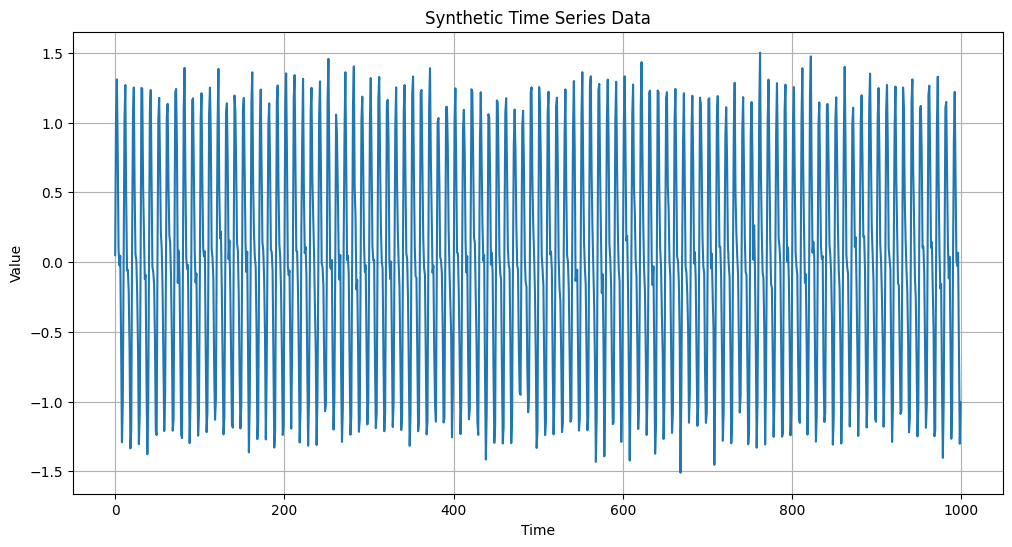

Input batch shape: torch.Size([128, 24, 1])
Target batch shape: torch.Size([128, 12, 1])
Model moved to: cuda:0
Epoch [10/100], Loss: 0.193258
Epoch [20/100], Loss: 0.033472
Epoch [30/100], Loss: 0.016111
Epoch [40/100], Loss: 0.010583
Epoch [50/100], Loss: 0.006919
Epoch [60/100], Loss: 0.006081
Epoch [70/100], Loss: 0.005564
Epoch [80/100], Loss: 0.005271
Epoch [90/100], Loss: 0.004988
Epoch [100/100], Loss: 0.004870


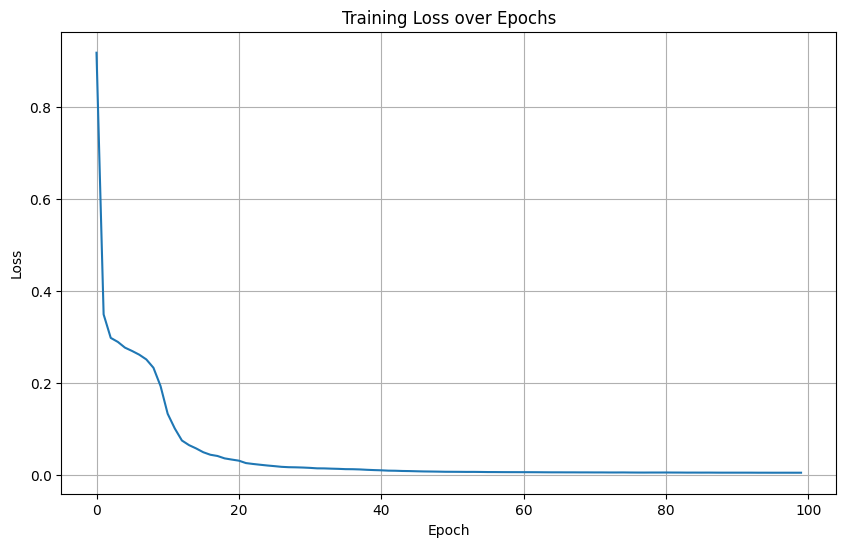

Test Loss: 0.005002


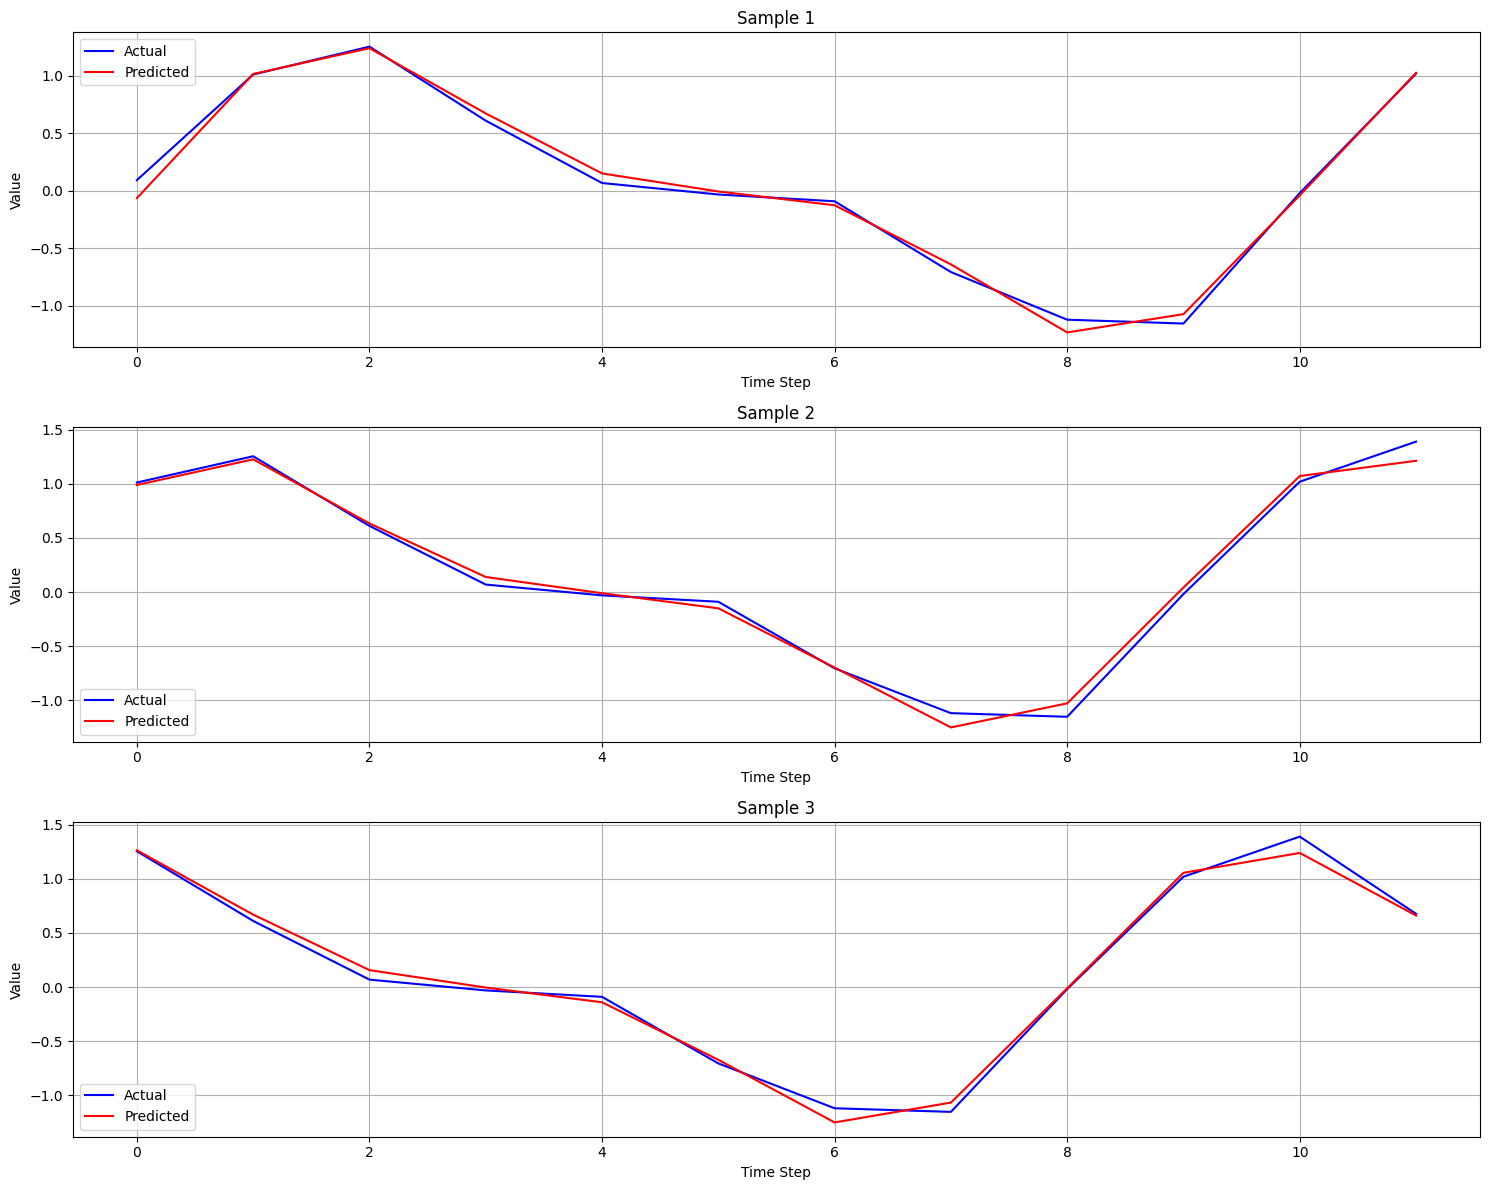

Attention weights shape: torch.Size([12, 128, 1, 24])


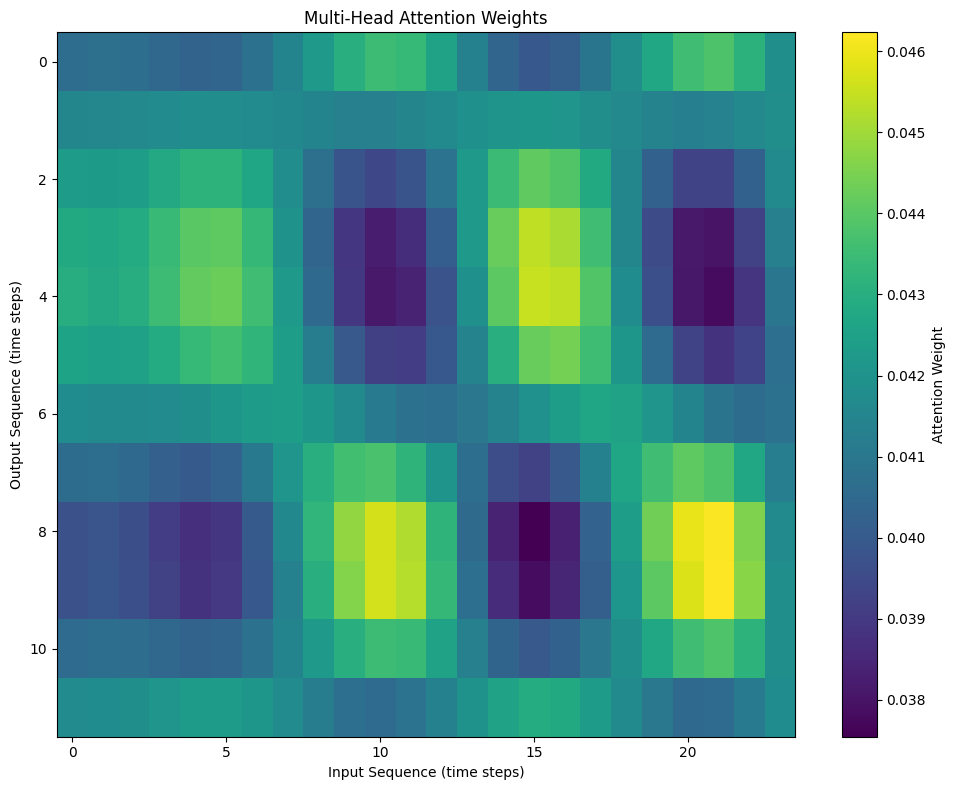

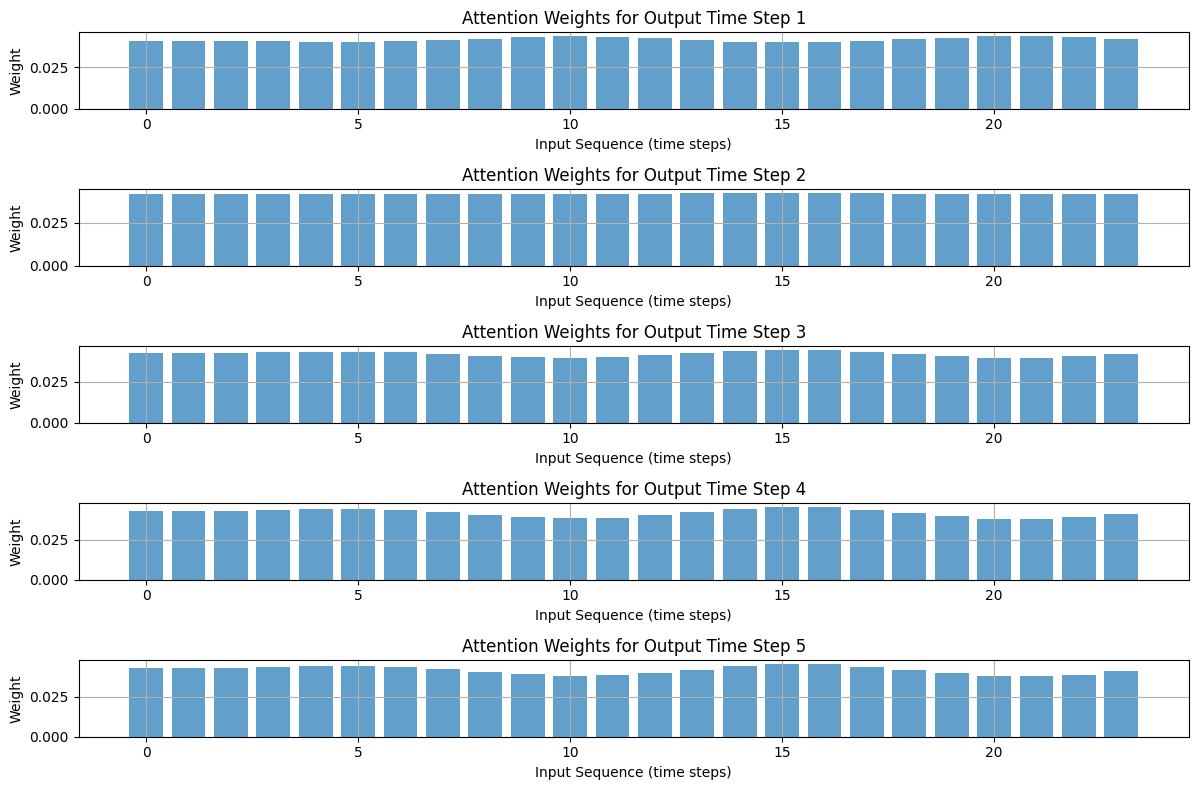

Mean Absolute Error (MAE): 0.0846
Root Mean Squared Error (RMSE): 0.1051
Mean Absolute Percentage Error (MAPE): 65.7855%
Processed attention shape for analysis: torch.Size([12, 24])


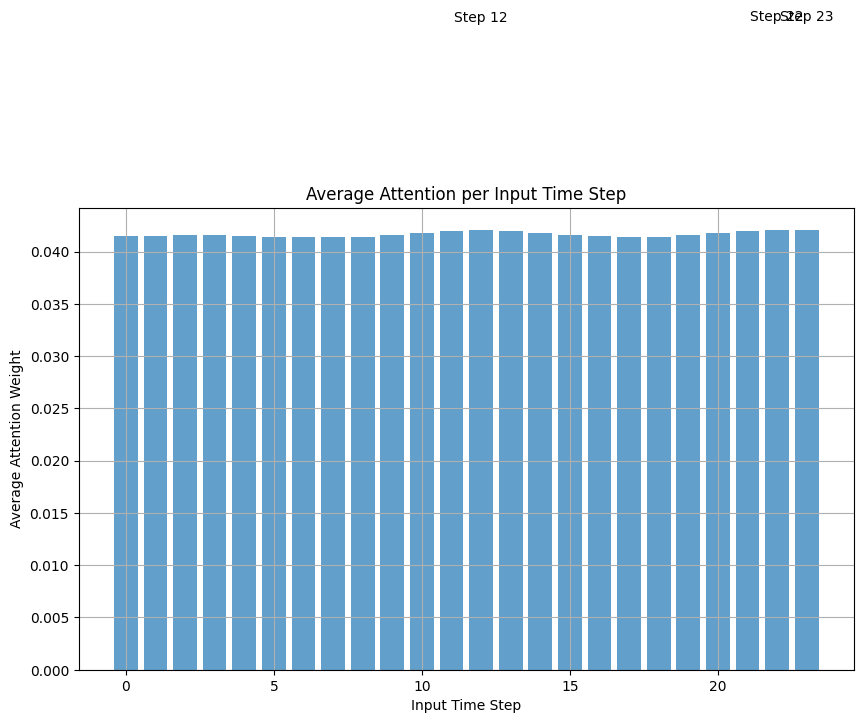

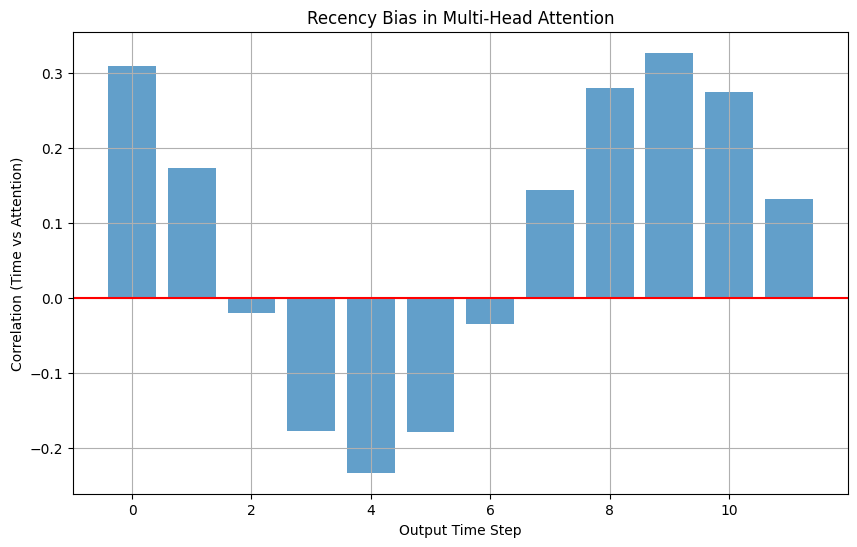

Multi-Head Attention Analysis Insights:
- Most attended input time steps: [22 23 12]
- Model somewhat focuses on distant past when making predictions


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import math

# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a synthetic time series
def generate_sine_wave(seq_length=1000, freq=0.1, noise_level=0.1):
    """Generate a synthetic sine wave with noise for time series forecasting"""
    x = np.arange(0, seq_length)
    # Create a sine wave with increasing frequency
    y = np.sin(2 * np.pi * freq * x) + 0.5 * np.sin(2 * np.pi * freq * 2 * x)
    # Add some noise
    noise = np.random.normal(0, noise_level, seq_length)
    y += noise
    return y

# Generate the time series data
time_series = generate_sine_wave(seq_length=1000)

# Plot the raw time series
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
time_series_normalized = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Create windowed data for sequence-to-sequence learning
class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, input_window=24, output_window=12, stride=1):
        """
        Create a dataset of windowed input/output sequences
        
        Args:
            time_series: The time series data (normalized)
            input_window: Number of input time steps
            output_window: Number of output time steps to predict
            stride: Step size between consecutive windows
        """
        self.time_series = time_series
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride
        
        # Calculate valid start indices for windows
        self.indices = np.arange(len(time_series) - (input_window + output_window) + 1, step=stride)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # Get the starting index for this window
        start_idx = self.indices[idx]
        
        # Extract input and target sequences
        input_seq = self.time_series[start_idx:start_idx + self.input_window]
        target_seq = self.time_series[start_idx + self.input_window:start_idx + self.input_window + self.output_window]
        
        # Convert to PyTorch tensors
        input_seq = torch.FloatTensor(input_seq).unsqueeze(1)  # Shape: [input_window, 1]
        target_seq = torch.FloatTensor(target_seq).unsqueeze(1)  # Shape: [output_window, 1]
        
        return input_seq, target_seq

# Create train/test splits
train_size = int(0.8 * len(time_series_normalized))
test_size = len(time_series_normalized) - train_size

train_data = time_series_normalized[:train_size]
test_data = time_series_normalized[train_size - 24:]  # Include some overlap for context

# Define dataset parameters
input_window = 24  # 24 time steps of history
output_window = 12  # Predict 12 time steps into the future
batch_size = 128

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train_data, input_window, output_window)
test_dataset = TimeSeriesDataset(test_data, input_window, output_window)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Let's see what a batch looks like
for x_batch, y_batch in train_loader:
    print(f"Input batch shape: {x_batch.shape}")  # [batch_size, input_window, 1]
    print(f"Target batch shape: {y_batch.shape}")  # [batch_size, output_window, 1]
    break

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers, 
                           batch_first=False)  # Input shape: [seq_len, batch, input_size]
    
    def forward(self, x):
        # x shape: [seq_len, batch, features]
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

# Define a single-head attention mechanism
class AttentionHead(nn.Module):
    def __init__(self, hidden_size, head_size):
        super(AttentionHead, self).__init__()
        self.hidden_size = hidden_size
        self.head_size = head_size
        
        # Query, Key, Value projections for a single head
        self.query = nn.Linear(hidden_size, head_size)
        self.key = nn.Linear(hidden_size, head_size)
        self.value = nn.Linear(hidden_size, head_size)
        
        # Scaling factor for dot product attention
        self.scale = math.sqrt(head_size)
    
    def forward(self, query, key, value):
        # query: [batch_size, query_len, hidden_size]
        # key: [batch_size, key_len, hidden_size]
        # value: [batch_size, value_len, hidden_size]
        
        # Project query, key, value
        query = self.query(query)  # [batch_size, query_len, head_size]
        key = self.key(key)        # [batch_size, key_len, head_size]
        value = self.value(value)  # [batch_size, value_len, head_size]
        
        # Compute scaled dot-product attention
        # (batch_size, query_len, head_size) x (batch_size, head_size, key_len)
        # -> (batch_size, query_len, key_len)
        attention_scores = torch.bmm(query, key.transpose(1, 2)) / self.scale
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply attention weights to values
        # (batch_size, query_len, key_len) x (batch_size, value_len, head_size)
        # -> (batch_size, query_len, head_size)
        context = torch.bmm(attention_weights, value)
        
        return context, attention_weights

# Define Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        
        # Make sure hidden_size is divisible by num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # Initialize multiple attention heads
        self.heads = nn.ModuleList([
            AttentionHead(hidden_size, self.head_size) for _ in range(num_heads)
        ])
        
        # Linear projection to combine heads
        self.output_projection = nn.Linear(num_heads * self.head_size, hidden_size)
    
    def forward(self, query, key, value):
        # Process with each attention head
        head_outputs = []
        head_attentions = []
        
        for head in self.heads:
            head_output, head_attention = head(query, key, value)
            head_outputs.append(head_output)
            head_attentions.append(head_attention)
        
        # Concatenate all head outputs
        multi_head_output = torch.cat(head_outputs, dim=-1)
        
        # Final projection
        output = self.output_projection(multi_head_output)
        
        # Store attention weights from all heads
        attention_weights = torch.stack(head_attentions, dim=1)  # [batch, num_heads, query_len, key_len]
        
        return output, attention_weights

# Define the Decoder with Multi-Head Attention
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads=4, num_layers=1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=hidden_size,
                           num_layers=num_layers, 
                           batch_first=False)  # Input shape: [seq_len, batch, input_size]
        
        # Multi-head attention mechanism
        self.attention = MultiHeadAttention(hidden_size, num_heads)
        
        # Layer normalization for stability
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden, cell, encoder_outputs):
        # x shape: [1, batch, features] - just one time step
        
        # Run through LSTM first
        lstm_output, (hidden, cell) = self.lstm(x, (hidden, cell))
        
        # Reshape for attention: [seq_len, batch, features] -> [batch, seq_len, features]
        lstm_output_reshaped = lstm_output.permute(1, 0, 2)
        encoder_outputs_reshaped = encoder_outputs.permute(1, 0, 2)
        
        # Apply multi-head attention
        # query = lstm output, key/value = encoder outputs
        attn_output, attn_weights = self.attention(
            lstm_output_reshaped, 
            encoder_outputs_reshaped, 
            encoder_outputs_reshaped
        )
        
        # Add and Norm (residual connection + layer normalization)
        lstm_output_reshaped = self.layer_norm1(lstm_output_reshaped + attn_output)
        
        # Generate prediction from the combined output
        prediction = self.fc(lstm_output_reshaped.squeeze(1))
        
        return prediction, hidden, cell, attn_weights

# Combine Encoder and Decoder into a Seq2Seq model with Multi-Head Attention
class MHASeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_window, num_heads=4, num_layers=1):
        super(MHASeq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, output_size, num_heads, num_layers)
        self.output_window = output_window
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def forward(self, source, target=None, teacher_forcing_ratio=0.5):
        batch_size = source.shape[1]
        seq_len = source.shape[0]
        
        # Move source to the device if needed
        if source.device != self.device:
            source = source.to(self.device)
            
        if target is not None and target.device != self.device:
            target = target.to(self.device)
        
        # Initialize the output tensor (on the same device as input)
        outputs = torch.zeros(self.output_window, batch_size, 1, device=self.device)
        
        # Initialize tensor to store all attention weights
        attention_weights = []
        
        # Pass source sequence through encoder
        encoder_outputs, hidden, cell = self.encoder(source)
        
        # First decoder input is the last value of the input sequence
        decoder_input = source[-1].unsqueeze(0)  # Shape: [1, batch, 1]
        
        # Iteratively predict each time step in the output window
        for t in range(self.output_window):
            # Pass through decoder with attention
            decoder_output, hidden, cell, attn_weights = self.decoder(
                decoder_input, hidden, cell, encoder_outputs)
            
            # Store the prediction and attention weights
            outputs[t] = decoder_output
            attention_weights.append(attn_weights)
            
            # Determine next input (teacher forcing or previous prediction)
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # Use ground truth as next input (teacher forcing)
                decoder_input = target[t].unsqueeze(0)
            else:
                # Use current prediction as next input
                decoder_input = decoder_output.unsqueeze(0)
                
        # Stack attention weights from all time steps
        attention_weights = torch.stack(attention_weights)  # [output_window, batch, num_heads, 1, input_window]
        
        return outputs, attention_weights

# Define model parameters
input_size = 1  # Univariate time series
hidden_size = 32
output_size = 1
num_layers = 2
num_heads = 4  # Number of attention heads

# Initialize the model and move it to the appropriate device
model = MHASeq2Seq(input_size, hidden_size, output_size, output_window, num_heads, num_layers)
model = model.to(device)
print(f'Model moved to: {next(model.parameters()).device}')

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=100, device=device):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Move tensors to the correct dimensions [seq_len, batch, features] and to device
            x_batch = x_batch.permute(1, 0, 2).to(device)
            y_batch = y_batch.permute(1, 0, 2).to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output, _ = model(x_batch, y_batch, teacher_forcing_ratio=0.5)
            
            # Make sure output is on the same device as y_batch
            if output.device != y_batch.device:
                output = output.to(y_batch.device)
                
            # Calculate loss
            loss = criterion(output, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to prevent explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    
    return losses

# Evaluation function
def evaluate_model(model, test_loader, criterion, device=device):
    model.eval()
    test_loss = 0
    predictions = []
    actual_values = []
    all_attention_weights = []
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # Move tensors to the correct dimensions [seq_len, batch, features] and to device
            x_batch = x_batch.permute(1, 0, 2).to(device)
            y_batch = y_batch.permute(1, 0, 2).to(device)
            
            # Forward pass
            output, attention_weights = model(x_batch, teacher_forcing_ratio=0)
            
            # Make sure output and y_batch are on the same device
            if output.device != y_batch.device:
                output = output.to(y_batch.device)
            
            # Calculate loss
            loss = criterion(output, y_batch)
            test_loss += loss.item()
            
            # Store predictions, actual values, and attention weights (detach and move to CPU for numpy conversion)
            predictions.append(output.permute(1, 0, 2).cpu())  # [batch, seq, features]
            actual_values.append(y_batch.permute(1, 0, 2).cpu())  # [batch, seq, features]
            all_attention_weights.append(attention_weights.cpu())
    
    # Process attention weights - this is more complex with multi-head attention
    # We'll average across heads for visualization purposes
    processed_attention = []
    for batch_attn in all_attention_weights:
        # Reshape and average across heads
        batch_attn = batch_attn.mean(dim=2)  # Average across heads
        batch_attn = batch_attn.squeeze(3)   # Remove the singleton dimension
        processed_attention.append(batch_attn)
    
    # Concatenate batches for predictions and actual values
    predictions = torch.cat(predictions, dim=0).numpy()
    actual_values = torch.cat(actual_values, dim=0).numpy()
    
    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.6f}')
    
    return predictions, actual_values, processed_attention, avg_loss

# Train the model
losses = train_model(model, train_loader, criterion, optimizer, epochs=100)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluate the model
predictions, actual_values, attention_weights, test_loss = evaluate_model(model, test_loader, criterion)

# Inverse transform the normalized values
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)
actual_values_original = scaler.inverse_transform(actual_values.reshape(-1, 1)).reshape(actual_values.shape)

# Function to visualize predictions
def plot_predictions(predictions, actual_values, num_samples=5):
    """Plot predictions vs actual values for a few samples"""
    plt.figure(figsize=(15, 12))
    
    for i in range(min(num_samples, len(predictions))):
        plt.subplot(num_samples, 1, i+1)
        
        # Plot actual values
        plt.plot(actual_values[i, :, 0], 'b-', label='Actual')
        
        # Plot predictions
        plt.plot(predictions[i, :, 0], 'r-', label='Predicted')
        
        plt.title(f'Sample {i+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualize a few predictions
plot_predictions(predictions_original, actual_values_original, num_samples=3)

# Function to visualize multi-head attention weights
def plot_multihead_attention(attention_weights, head_idx=0, sample_idx=0):
    """
    Visualize attention weights for a specific head and sample
    
    Args:
        attention_weights: Processed attention weights from the model evaluation
        head_idx: Which head to visualize (0 to num_heads-1)
        sample_idx: Index of the sample to visualize
    """
    # Check the shape of the attention weights and handle accordingly
    print(f"Attention weights shape: {attention_weights[0].shape}")
    
    # If attention_weights is a list, get the sample
    if isinstance(attention_weights, list):
        if len(attention_weights) <= sample_idx:
            print(f"Sample index {sample_idx} is out of range. Using sample 0 instead.")
            sample_idx = 0
        attn = attention_weights[sample_idx]
    else:
        attn = attention_weights
    
    # If the tensor has 4 dimensions, we need to squeeze or select specific dimensions
    if len(attn.shape) == 4:  # [output_window, num_heads, 1, input_window]
        # Select the specified head and remove the singleton dimension
        attn = attn[:, head_idx, 0, :]
    elif len(attn.shape) == 3 and attn.shape[2] == 1:  # [output_window, input_window, 1]
        # Remove the singleton dimension
        attn = attn[:, :, 0]
    
    # Make sure we have a 2D tensor now
    assert len(attn.shape) == 2, f"Attention shape after processing is {attn.shape}, expected 2D"
    
    # Now we can visualize it
    plt.figure(figsize=(10, 8))
    plt.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title(f'Multi-Head Attention Weights')
    plt.xlabel('Input Sequence (time steps)')
    plt.ylabel('Output Sequence (time steps)')
    plt.tight_layout()
    plt.show()
    
    # Also show attention as line plots for each output time step
    plt.figure(figsize=(12, 8))
    output_window, input_window = attn.shape
    for i in range(min(output_window, 5)):  # Show first 5 output steps at most
        plt.subplot(5, 1, i+1)
        plt.bar(range(input_window), attn[i], alpha=0.7)
        plt.title(f'Attention Weights for Output Time Step {i+1}')
        plt.xlabel('Input Sequence (time steps)')
        plt.ylabel('Weight')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize attention weights for a sample
plot_multihead_attention(attention_weights)

# Calculate error metrics
def calculate_metrics(predictions, actual_values):
    """Calculate common error metrics for time series forecasting"""
    # Reshape to 2D arrays for calculations
    y_true = actual_values.reshape(-1)
    y_pred = predictions.reshape(-1)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true + 1e-10))) * 100
    
    return mae, rmse, mape

# Calculate and print metrics
mae, rmse, mape = calculate_metrics(predictions_original, actual_values_original)
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

# Analyze attention patterns across heads
def analyze_multihead_attention(attention_weights, sample_idx=0):
    """
    Analyze attention patterns across different heads
    
    Args:
        attention_weights: Processed attention weights from the model
        sample_idx: Index of the sample to analyze
    """
    # Process attention weights for analysis
    if isinstance(attention_weights, list):
        if len(attention_weights) <= sample_idx:
            print(f"Sample index {sample_idx} is out of range. Using sample 0 instead.")
            sample_idx = 0
        attn = attention_weights[sample_idx]
    else:
        attn = attention_weights
    
    # Handle different possible shapes
    if len(attn.shape) == 4:  # [output_window, num_heads, 1, input_window]
        # Average across heads and remove singleton dimension
        attn = attn.mean(dim=1)[:, 0, :]
    elif len(attn.shape) == 3 and attn.shape[2] == 1:  # [output_window, input_window, 1]
        attn = attn[:, :, 0]
    
    # Now we should have a 2D tensor [output_window, input_window]
    print(f"Processed attention shape for analysis: {attn.shape}")
    
    # Calculate the average attention for each input time step
    avg_attention = np.mean(attn.cpu().numpy(), axis=0)
    
    # Find the most attended input time steps
    most_attended_indices = np.argsort(-avg_attention)[:3]  # Top 3 most attended
    
    # Visualize the average attention per input time step
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(avg_attention)), avg_attention, alpha=0.7)
    plt.title('Average Attention per Input Time Step')
    plt.xlabel('Input Time Step')
    plt.ylabel('Average Attention Weight')
    for idx in most_attended_indices:
        plt.annotate(f"Step {idx}", 
                    xy=(idx, avg_attention[idx]),
                    xytext=(idx, avg_attention[idx] + 0.02),
                    ha='center')
    plt.grid(True)
    plt.show()
    
    # Find which future time steps pay most attention to recent vs distant past
    recency_bias = []
    for i in range(attn.shape[0]):  # For each output time step
        # Calculate the correlation between time step index and attention weight
        # Negative correlation means more attention to recent steps
        # Positive correlation means more attention to distant past
        step_indices = np.arange(attn.shape[1])
        correlation = np.corrcoef(step_indices, attn[i])[0, 1]
        recency_bias.append(correlation)
    
    # Visualize recency bias per output time step
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(recency_bias)), recency_bias, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Recency Bias in Multi-Head Attention')
    plt.xlabel('Output Time Step')
    plt.ylabel('Correlation (Time vs Attention)')
    plt.grid(True)
    plt.show()
    
    # Print insights
    print("Multi-Head Attention Analysis Insights:")
    print(f"- Most attended input time steps: {most_attended_indices}")
    
    # Determine if the model focuses more on recent or distant past
    avg_recency_bias = np.mean(recency_bias)
    if avg_recency_bias < -0.3:
        print("- Model strongly focuses on recent past when making predictions")
    elif avg_recency_bias < 0:
        print("- Model somewhat focuses on recent past when making predictions")
    elif avg_recency_bias > 0.3:
        print("- Model strongly focuses on distant past when making predictions")
    elif avg_recency_bias > 0:
        print("- Model somewhat focuses on distant past when making predictions")
    else:
        print("- Model shows no clear bias towards recent or distant past")

# Analyze attention patterns
analyze_multihead_attention(attention_weights)